## **Гипотеза №1**
### $H_{0}$ : Количество ночных клубов и баров рядом с квартирой в радиусе 200 метров не влияет на ее стоимость
### $H_{1}$ : Количество ночных клубов и баров рядом с квартирой в радиусе 200 метров влияет на ее стоимость
### Уровень статистической значимости = 0.05

## **Импорт библиотек**

In [1]:
import pandas as pd #библиотека для обработки и анализа данных в виде таблиц
import numpy as np #библиотека, добавляющая поддержку больших многомерных массивов и матриц, вместе с большой библиотекой высокоуровневых математических функций для операций с этими массивами

#scikit-learn — это библиотека, предназначенная для машинного обучения
from sklearn.linear_model import LinearRegression #линейная регрессия
from sklearn import preprocessing #предоставляет функции для преобразования данных в более подходящий вид для последующих оценок

import statsmodels.api as sm #позволяет исследовать данные, оценивать статистические модели и выполнять статистические тесты
import scipy.stats as stats
import seaborn as sns #эта библиотека предназначена для создания статистических графиков

from pyhive import hive

## **Подключение к базе данных и импорт данных**

In [2]:
#mart1 = pd.read_csv('mart1.csv')
conn = hive.Connection(host='localhost', port=10000, database='project')
cursor = conn.cursor()
query = "SELECT * FROM mart_1"
mart1 = pd.read_sql(query, conn)

/tmp/ipykernel_14317/1774751069.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mart1 = pd.read_sql(query, conn)


In [3]:
mart1.head()

,mart_1.id,mart_1.price,mart_1.district,mart_1.rooms,mart_1.total_area,mart_1.current_floor,mart_1.max_floor,mart_1.build_year,mart_1.bath,mart_1.repair,mart_1.window_type,mart_1.places_total
0,1,6000000,Щербинка,1.0,NaN,3,5,1974.0,1 совмещенный,Косметический,Во двор,0
1,13,6999990,Коммунарка поселок,NaN,NaN,10,16,2022.0,1 совмещенный,Косметический,Во двор,0
2,50,3756000,Старое Крюково,NaN,NaN,2,9,NaN,1 совмещенный,Косметический,На улицу и двор,0
3,65,4300000,Текстильщики,NaN,NaN,1,5,1957.0,1 совмещенный,Косметический,Во двор,0
4,76,6800000,Очаково-Матвеевское,NaN,NaN,8,9,NaN,1 совмещенный,Евроремонт,На улицу,0


## **Очищение и преобразование данных**

**Выброс** — это наблюдение, которое лежит аномально далеко от других значений в наборе данных. Выбросы могут быть проблематичными, поскольку они могут повлиять на результаты анализа.
Для удаления выбросов будем использовать межквартильный диапазон.

**Межквартильный размах (IQR)** — это разница между 75-м процентилем (Q3) и 25-м процентилем (Q1) в наборе данных. Он измеряет разброс средних 50% значений.
Можно определить наблюдение как выброс, если оно в 1,5 раза превышает межквартильный размах, превышающий третий квартиль (Q3), или в 1,5 раза превышает межквартильный размах, меньше первого квартиля (Q1).
Выбросы = наблюдения > Q3 + 1,5*IQR или Q1 – 1,5*IQR

In [4]:
q3, q1 = np.percentile(mart1['mart_1.price'], [75, 25]) #получаем 75-й и 25-й процентили колонки price
IQR = q3 - q1 #рассчитываем межквартильный размах
upper_bound = q3 + 1.5 * IQR #получаем высшую границу
lower_bound = q1 - 1.5 * IQR #получаем низшую границу

mart1 = mart1[(mart1['mart_1.price'] < upper_bound) & (mart1['mart_1.price'] > lower_bound)] #выбираем только те записи, у которых цена находится в пределах границ

In [5]:
#линейная регрессия не может работать со строками, их нужно заменить на числовые значения
le = preprocessing.LabelEncoder() #(Кодирование меток) - метод, который присваивает каждому уникальному значению категориального признака уникальное целочисленное значение
le.fit(mart1['mart_1.district'])
mart1['district_num'] = le.transform(mart1['mart_1.district']) #создание нового столбца с замененными строковыми данными на целочисленные

Выбираем нужные столбцы и удаляем записи с пропущенными значениями

In [6]:
model_data = mart1.loc[:, ['mart_1.price', 'district_num', 'mart_1.rooms', 'mart_1.current_floor', 'mart_1.build_year', 'mart_1.places_total']].dropna()

## **Регрессионный анализ**

Проверяем данные на мультиколлинеарность, так как для линейной регрессии атрибуты не должны иметь связи

<Axes: >

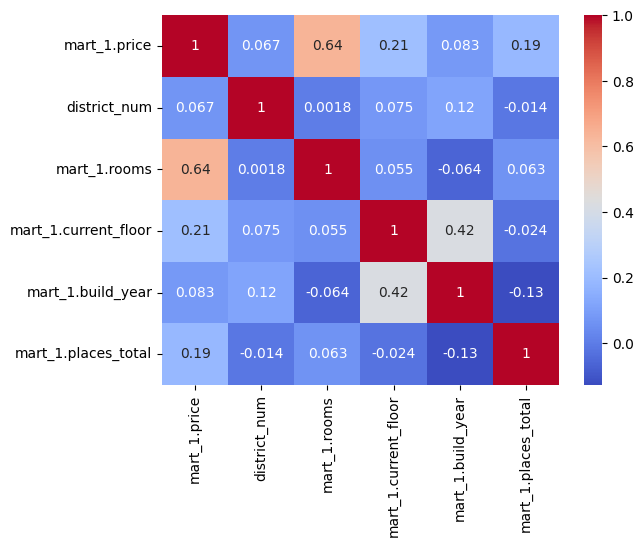

In [7]:
sns.heatmap(model_data.corr(), annot=True, cmap='coolwarm')

In [8]:
X = model_data.loc[:, ['district_num', 'mart_1.rooms', 'mart_1.current_floor', 'mart_1.build_year', 'mart_1.places_total']] #В качестве X выбираем независимые переменные
Y = model_data['mart_1.price'] #В качестве Y выбираем зависимую переменную, в нашем случае, цену

Проводим регрессионный анализ

In [12]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mart_1.price   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     405.1
Date:                Thu, 20 Apr 2023   Prob (F-statistic):          4.41e-312
Time:                        13:46:28   Log-Likelihood:                -39639.
No. Observations:                2302   AIC:                         7.929e+04
Df Residuals:                    2296   BIC:                         7.932e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.713e+07   1.25e+07     -4.558      0.000   -8.17e+07   -3.26e+07
district_num          1.128e+04   3545.784      3.181      0.001    4326.341    1.82e+04
mart_1.rooms          7.391e+06   1.82e+05     40.717      0.000    7.03e+06    7.75e+06
mart_1.current_floor  2.325e+05   2.67e+04      8.703      0.000     1.8e+05    2.85e+05
mart_1.build_year     2.803e+04   6330.600      4.428      0.000    1.56e+04    4.04e+04
mart_1.places_total   8.942e+05   8.55e+04     10.457      0.000    7.27e+05    1.06e+06
==============================================================================
Omnibus:                      391.909   Durbin-Watson:                   0.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              744.203
Skew:                           1.040   Prob(JB):                    2.50e-162
Kurtosis:                       4.854   Cond. No.                     1.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## **Выводы**
Коэффициент атрибута places_total равняется $8.942 * 10^5$ и имеет p-value < уровня статистической значимости (0.05), значит мы опровергаем нулевую гипотезу, следовательно связь есть. Более того, исходя из коэффициента регресси можно сделать вывод о том, что наличие рядом ночных клубов и баров рядом с квартирой увеличивает ее стоимость.